In [40]:
import os
import random

import numpy as np
import wfdb
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
os.chdir('..')

In [28]:
data = pd.read_csv('data_ptb-xl/ptbxl_database.csv')
data = data.loc[data['report'] != ' '] # remove 2 rows without a report
data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


## Train - Val - Test Split

In [60]:
# Split the data as suggested in https://physionet.org/content/ptb-xl/1.0.3/
train = data[~data['strat_fold'].isin([9, 10])].copy()
val = data[data['strat_fold'] == 9].copy()
test = data[data['strat_fold'] == 10].copy()

print(f"train: {round(len(train) / len(data) * 100, 2)} %")
print(f"val:   {round(len(val) / len(data) * 100, 2)} %")
print(f"test:  {round(len(test) / len(data) * 100, 2)} %")

train: 79.91 %
val:   10.02 %
test:  10.08 %


In [61]:
# Check for patient_id intersections
train_patients = set(train['patient_id'])
val_patients = set(val['patient_id'])
test_patients = set(test['patient_id'])

train_val_overlap = train_patients & val_patients
train_test_overlap = train_patients & test_patients
val_test_overlap = val_patients & test_patients

print("Train-Validation Overlap:", len(train_val_overlap))
print("Train-Test Overlap:", len(train_test_overlap))
print("Validation-Test Overlap:", len(val_test_overlap))

Train-Validation Overlap: 0
Train-Test Overlap: 0
Validation-Test Overlap: 0


# Report Translation

This [paper](https://arxiv.org/pdf/2103.11011) has already translated the PTB-XL dataset into their [github](https://github.com/danikiyasseh/RTLP/tree/main/translations) repository. They are using the older version 1.0.1 of PTB-XL. In the newer versions of PTB-XL, they removed duplicates and changed the ages above 89 years to 300 for privacy reasons. So the changes shouldn't affect the reports itself. We are using PTB-XL 1.0.3.
So we can concatenate the translated reports with our new data depending on the `ecg_id`.

There are alot missing `ecg_id`'s in the version 1.0.1, so we took translation from google api.

In [62]:
translated_df = pd.read_csv('data_ptb-xl/translated_report/report_translated_by_google.csv')
translated_df.head()

,ecg_id,translation
0,1,sinus rhythm peripheral low voltage
1,2,sinus bradycardia otherwise normal ecg
2,3,sinus rhythm normal ecg
3,4,sinus rhythm normal ecg
4,5,sinus rhythm normal ecg


In [63]:
def concatenate_dataframes(df, df_translation):
    merged_df = df.merge(df_translation[['ecg_id', 'translation']], on='ecg_id', how='left')
    merged_df.rename(columns={'translation': 'preprocessed_report'}, inplace=True)
    return merged_df

In [64]:
train = concatenate_dataframes(train, translated_df)
train.to_csv('data_ptb-xl/train.csv', index=False)

In [65]:
val = concatenate_dataframes(val, translated_df)
val.to_csv('data_ptb-xl/val.csv', index=False)

In [66]:
test = concatenate_dataframes(test, translated_df)
test.to_csv('data_ptb-xl/test.csv', index=False)

In [67]:
all_words = train['report'].str.split().explode()
unique_words = set(all_words)
print(f"Number of unique words in report: {len(unique_words)}")

Number of unique words in report: 3159


In [68]:
all_words = train['preprocessed_report'].str.split().explode()
unique_words = set(all_words)
print(f"Number of unique words in preprocessed report: {len(unique_words)}")

Number of unique words in preprocessed report: 2954


# Bag of Words

In [69]:
n_words = 50

In [77]:
train = pd.read_csv('data_ptb-xl/train.csv')

vectorizer = CountVectorizer(max_features=n_words, binary=True)
train_BoW = vectorizer.fit_transform(train['preprocessed_report'])

train_BoW = pd.DataFrame(train_BoW.toarray(), columns=vectorizer.get_feature_names_out())
train_BoW = pd.concat([train['ecg_id'].reset_index(drop=True), train_BoW], axis=1)
train_BoW['ecg_id'] = train_BoW['ecg_id'].astype(int)

train_BoW.to_csv(f'data_ptb-xl/bag_of_words/train_{n_words}_BoW.csv', index=False)

In [78]:
val = pd.read_csv('data_ptb-xl/val.csv')

val_BoW = vectorizer.transform(val['preprocessed_report'])

val_BoW = pd.DataFrame(val_BoW.toarray(), columns=vectorizer.get_feature_names_out())
val_BoW = pd.concat([val['ecg_id'].reset_index(drop=True), val_BoW], axis=1)
val_BoW['ecg_id'] = val_BoW['ecg_id'].astype(int)

val_BoW.to_csv(f'data_ptb-xl/bag_of_words/val_{n_words}_BoW.csv', index=False)

In [79]:
test = pd.read_csv('data_ptb-xl/test.csv')

test_BoW = vectorizer.transform(test['preprocessed_report'])

test_BoW = pd.DataFrame(test_BoW.toarray(), columns=vectorizer.get_feature_names_out())
test_BoW = pd.concat([test['ecg_id'].reset_index(drop=True), test_BoW], axis=1)
test_BoW['ecg_id'] = test_BoW['ecg_id'].astype(int)

test_BoW.to_csv(f'data_ptb-xl/bag_of_words/test_{n_words}_BoW.csv', index=False)

In [80]:
for word in train_BoW.columns:
    print(word, end=', ')

ecg_id, 46, abnormal, age, amp, anterior, anteroseptal, are, atrial, axis, be, block, branch, bundle, ecg, fibrillation, high, hypertrophy, in, infarction, inferior, ischemia, lateral, leads, left, low, myocardial, non, nonspecific, normal, old, or, otherwise, position, possible, probable, probably, qrs, report, rhythm, right, sinistrocardiale, sinus, specific, st, strain, to, type, unconfirmed, ventricular, waves, 

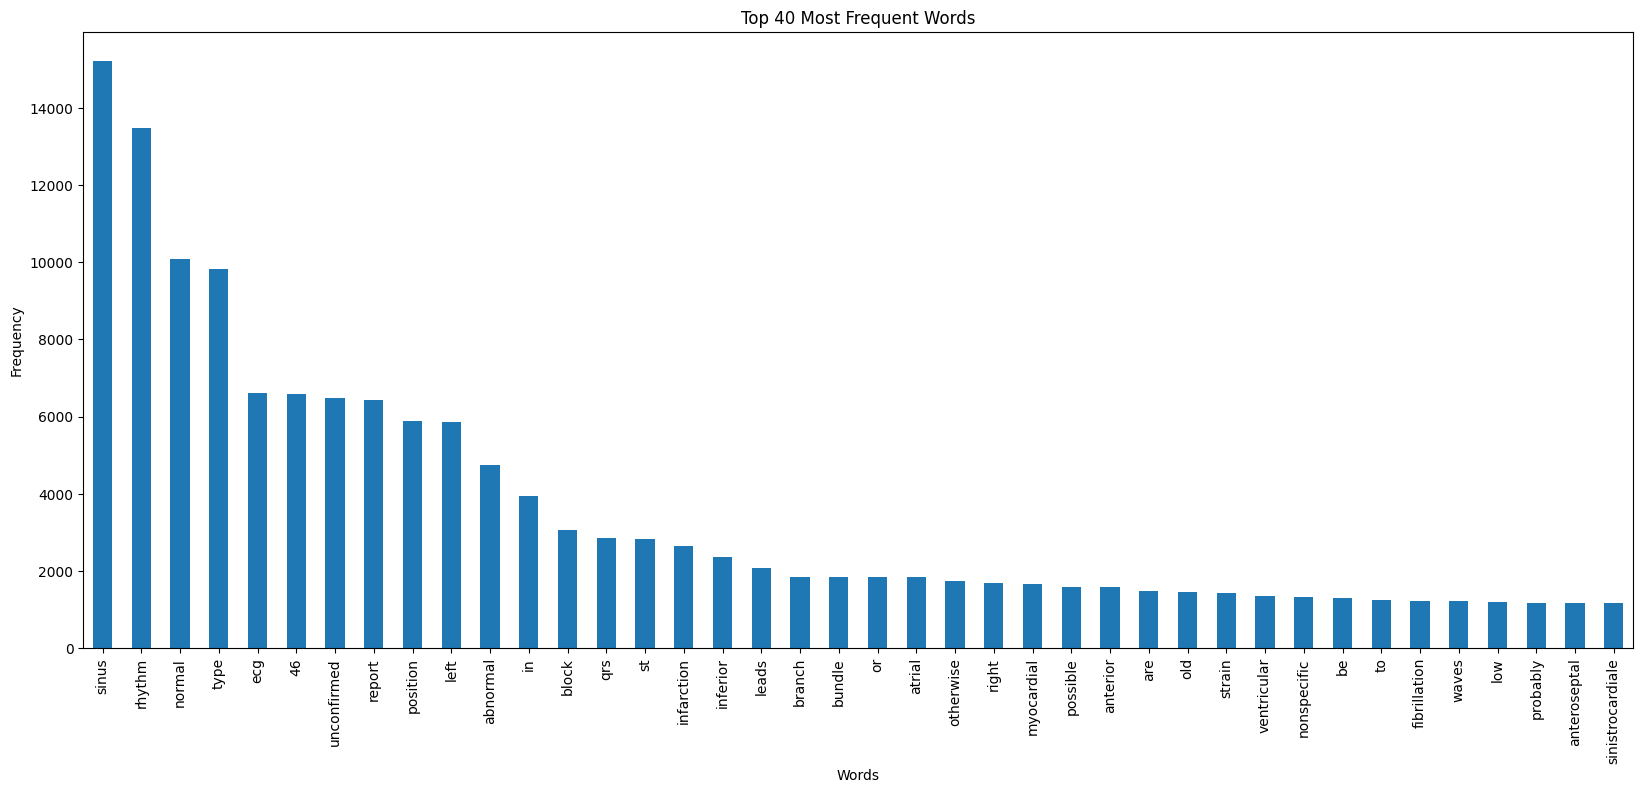

In [89]:
import matplotlib.pyplot as plt

# train_BoW.set_index('ecg_id', inplace=True)
word_counts = train_BoW.sum(axis=0).sort_values(ascending=False)
top_20_words = word_counts.head(40)

plt.figure(figsize=(20, 8))
top_20_words.plot(kind='bar')
plt.title('Top 40 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [82]:
data.loc[data['report'].str.contains('46')]

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
3054,3069,10781.0,55.0,0,NaN,NaN,1.0,2.0,AT-60 3,1989-07-09 15:01:09,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/03000/03069_lr,records500/03000/03069_hr
3194,3209,9254.0,73.0,1,NaN,NaN,1.0,2.0,AT-60 3,1989-07-27 16:43:23,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/03000/03209_lr,records500/03000/03209_hr
3215,3230,18090.0,300.0,1,NaN,NaN,1.0,2.0,AT-60 3,1989-07-29 17:13:38,...,True,NaN,", alles,",NaN,NaN,NaN,NaN,7,records100/03000/03230_lr,records500/03000/03230_hr
4303,4323,18026.0,60.0,1,NaN,NaN,0.0,0.0,CS100 3,1990-07-01 06:08:44,...,False,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/04000/04323_lr,records500/04000/04323_hr
4306,4326,9390.0,48.0,0,NaN,NaN,0.0,0.0,CS100 3,1990-07-01 09:00:37,...,False,NaN,NaN,alles,NaN,NaN,NaN,4,records100/04000/04326_lr,records500/04000/04326_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21795,21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21796,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr
21797,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr


In [83]:
# unconfirmed report
len(data.loc[data['report'].str.contains('unbestÄtigter bericht') & data['report'].str.contains('46')])

6813